In [1]:
import os.path
import pandas as pd
import geopandas as gpd
from libpysal.weights import Rook
from esda.moran import Moran_Local
from splot._viz_esda_mpl import lisa_cluster

In [2]:
data_dir = "./data"

In [3]:
region_file = os.path.join(data_dir, 'districts-generalized.gpkg')
gdf = gpd.read_file(region_file)
gdf = gdf[gdf.geometry!=None]

In [4]:
timeseries_file = os.path.join(data_dir, 'covid-timeline.csv')
cov_df = pd.read_csv(timeseries_file, delimiter=';', parse_dates=True)
cov_df = cov_df[cov_df.Time=='18.11.2020 00:00:00']
cov_df['GKZ'] = cov_df['GKZ'].astype(int)

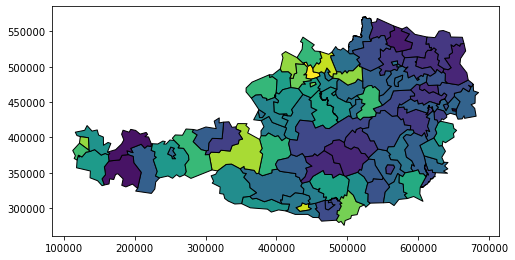

In [5]:
joined = cov_df.set_index('GKZ').join(gdf.set_index('GKZ'), rsuffix='g')
joined['cases_per_100k'] = joined['AnzahlFaelle'] / (joined['AnzEinwohner']/100000)
joined_gdf = gpd.GeoDataFrame(joined)
joined_gdf.plot(column='cases_per_100k', edgecolor='black', figsize=(8,8))

In [6]:
w = Rook.from_dataframe(joined_gdf)

In [7]:
y = joined_gdf['cases_per_100k']

In [8]:
moran_loc = Moran_Local(y, w)

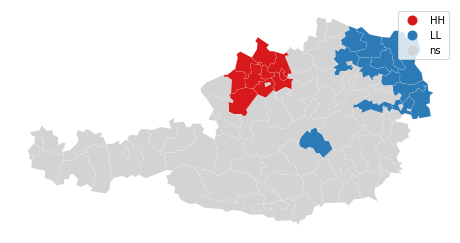

In [9]:
f, ax = lisa_cluster(moran_loc, joined_gdf, figsize=(8,8))

In [10]:
joined_gdf['cardinality'] = list(w.cardinalities.values())

In [11]:
joined_gdf['li_z']= moran_loc.z

In [12]:
joined_gdf[joined_gdf.cardinality==1]

,Time,Bezirk,AnzEinwohner,AnzahlFaelle,AnzahlFaelleSum,AnzahlFaelle7Tage,SiebenTageInzidenzFaelle,AnzahlTotTaeglich,AnzahlTotSum,AnzahlGeheiltTaeglich,AnzahlGeheiltSum,id,name,geometry,cases_per_100k,cardinality,li_z
GKZ,,,,,,,,,,,,,,,,,
101,18.11.2020 00:00:00,Eisenstadt(Stadt),14816,7,318,54,364.4709,0,0,5,208,101,Eisenstadt(Stadt),"POLYGON ((641439.810 447710.370, 635620.340 44...",47.246220,1,-0.582115
302,18.11.2020 00:00:00,Sankt Pölten(Stadt),55514,33,1273,260,468.3503,0,8,0,525,302,Sankt Pölten(Stadt),"POLYGON ((566378.110 476332.280, 567551.150 47...",59.444464,1,-0.283681
312,18.11.2020 00:00:00,Korneuburg,91254,21,1675,211,231.2227,0,7,39,1210,312,Korneuburg,"POLYGON ((596769.410 507264.050, 596745.600 50...",23.012690,1,-1.174995
403,18.11.2020 00:00:00,Wels(Stadt),62470,89,2019,407,651.5128,0,9,4,1065,403,Wels(Stadt),"POLYGON ((448079.550 471068.630, 456286.890 47...",142.468385,1,1.747523
501,18.11.2020 00:00:00,Salzburg(Stadt),155021,106,3527,918,592.1779,0,11,15,2081,501,Salzburg(Stadt),"POLYGON ((374290.950 437012.260, 376243.980 42...",68.377833,1,-0.065124
601,18.11.2020 00:00:00,Graz(Stadt),291072,93,5682,1072,368.2938,1,59,151,3463,601,Graz(Stadt),"POLYGON ((554296.670 357095.740, 555046.060 34...",31.950858,1,-0.956320
701,18.11.2020 00:00:00,Innsbruck-Stadt,131961,81,4857,528,400.1182,0,42,73,3871,701,Innsbruck-Stadt,"POLYGON ((252272.910 373773.180, 253079.020 36...",61.381772,1,-0.236285


In [13]:
import seaborn as sns

In [14]:
df = joined_gdf

In [15]:
df['card1'] = df.cardinality==1
df['z_sim'] = moran_loc.z_sim

## Impact of neighbor caridinality on z

First we examine the z values for the local Moran I statistics based on conditional random permutations:

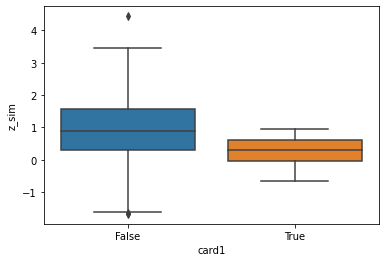

In [16]:
_= sns.boxplot(x='card1', y='z_sim',  data=df)

The z values for observations with only 1 neighbor are much more concentrated. This is because, the Local I values that are generated under conditional random permutations will have larger variance:

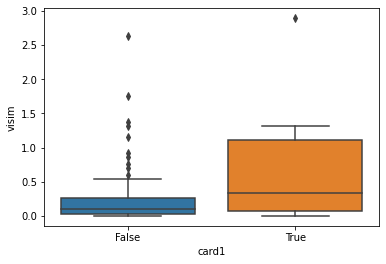

In [17]:
df['visim'] = moran_loc.VI_sim
_ = sns.boxplot(x='card1', y='visim', data=df)